# Convolutional Neural Network Architectures 3 - Network in Network

Welcome to the 6th notebook! In this module, we will explore an influential architecture known as the Network in Network (NiN) architecture. NiN introduces a unique approach to leveraging the power of convolutional neural networks by incorporating specific layers we have discussed earlier, such as Global Average Pooling and 1x1 convolutions.

Network in Network proposed by Min Lin, Qiang Chen and Shuicheng Yan in 2013 in their paper named [Network In Network](https://arxiv.org/abs/1312.4400). After AlexNet was proposed, a common design pattern arised which depended on extracting features by deepening the model with a sequence of convolutions and pooling layers, and finally classifying via the fully connected layers. This design pattern also extended in other architectures, for instance, VGG as we will soon see. This design pattern also brings a huge amount of computational need. In Network in Network paper, the authors proposed an architecture that not only aims to address this issue but also an architecture capable of capturing complex features.

## Multilayer Perceptron Convolution Layers

<img src="imgs/nin1.PNG" width="70%">
<a href=""> Source </a>

NiN proposed replacing the linear convolution filters used in traditional CNNs with a new type of layer called the mlpconv layer, which combines a traditional convolutional layer with a small Multi-Layer Perceptron (MLP) applied in a small receptive field. The mlpconv consists of a multilayer perceptron (MLP) followed by a 1x1 convolutional layer.

* This linear convolution is sufficient for abstraction when the instances of the latent concepts are linearly separable. However, representations that achieve good abstraction are generally highly nonlinear functions of the input data. In conventional CNN, this might be compensated by utilizing an over-complete set of filters to cover all variations of the latent concepts. Namely, individual linear filters can be learned to detect different variations of a same concept. However, having too many filters for a single concept imposes extra burden on the next layer, which needs to consider all combinations of variations from the previous layer. As in CNN, filters from higher layers map to larger regions in the original input. It generates a higher level concept by combining the lower level concepts from the layer below. Therefore, we argue that it would be beneficial to do a better abstraction on each local patch, before combining them into higher level concepts. - [Network In Network](https://arxiv.org/abs/1312.4400)

This idea led to the development of the Network in Network architecture, where instead of using a single linear convolution filter for each convolutional layer, a combined convolutional and MLP were used. By using MLPs, the Network in Network architecture can model more complex functions (since we will introduce non-linearity in each layer), thus enabling better feature extraction capabilities. Additionally, using MLPs in a small receptive field can reduce the number of parameters required in the model, while still achieving good performance, thus addressing the issue of the requirement for a large number of filters in traditional CNNs while saving computational resources.

<img src="imgs/ninblock.PNG" width="15%">
<a href=""> Source </a>

Each NiN block consists of one convolutional layer with a larger kernel size and two one-by-one convolutional layers. As we previously discussed, these 1x1 convolutional layers can be interpreted as a multi-layer perceptron layer since a 1x1 convolution layer applies a dot product operation between the filter and the input at each spatial location, similar to how a fully connected layer operates on a single input vector. These three layers also apply non-linearity three times, making the model capable of capturing non-linear relationships better.



<img src="imgs/ninarchitecture.PNG" width="75%">
<a href=""> Source </a>

NiN architecture stacks three mlpconv layers on top of each other (but I will stack four as represented above) and then applies global average pooling (GAP was actually first introduced in the NiN paper) which takes the average value of each feature map in the final convolutional layer, resulting in a single value for each feature map. This effectively flattens the feature maps into a vector of size equal to the number of feature maps, which can be fed directly into a fully connected layer for classification. By using Global Average Pooling, we further reduce the number of trainable parameters and save computational resources. Moreover, the authors argue that GAP has a regularization effect as well.


For more about 1x1 convolutions and global average pooling, please refer to my previous notebooks. Moreover, I do recommend checking out the paper, the authors did some further experiments with the model such as using fully connected layers or using dropout which you may want to check.

# Rock-Paper-Scissors Dataset

I will train the sequential model on Rock-Paper-Scissors dataset. I take the steps to load the dataset from the following [notebook](https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=k4cHfXyQLt8a).


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [ ]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

Let's visualize some of the instances from the dataset.

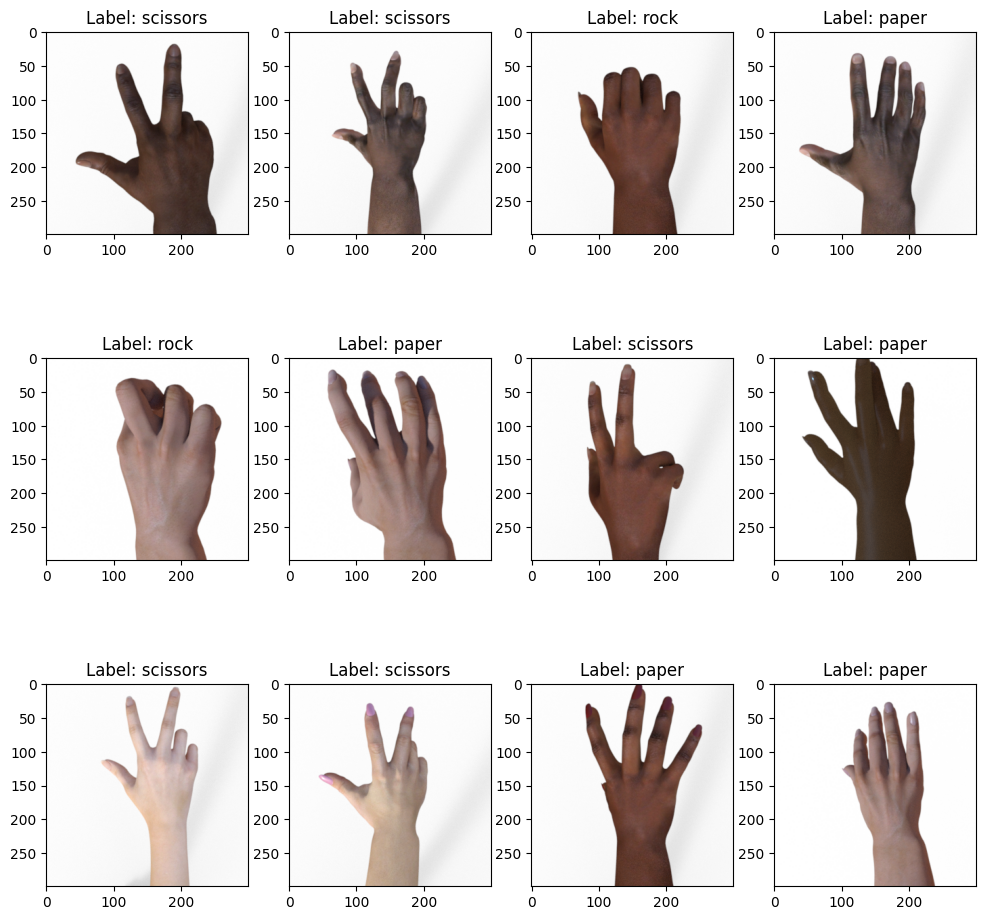

In [ ]:
from dataprocessing import preview_dataset
# Explore raw training dataset images.
preview_dataset(dataset_train_raw, get_label_name)

Now we can pre-process the images in the dataset and create train and test sets.

In [ ]:
from dataprocessing import format_example
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [ ]:
BATCH_SIZE = 32

dataset_train_shuffled = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_shuffled = dataset_train.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_shuffled = dataset_train_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [ ]:
print(dataset_train_shuffled)
print(dataset_test_shuffled)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Training NiN

Time to implement the architecture. This time I will not be using `tensorflow.keras.Sequential()` since the architecture has an unusual structure, it is much easier to use functional API for implementation.

In [2]:
class NiNModel(tf.keras.Model):
    def __init__(self, output):
        super(NiNModel, self).__init__()
        self.block1 = self.nin_block(96, 11, 4, padding='valid')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)
        self.block2 = self.nin_block(256, 5, 1)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)
        self.block3 = self.nin_block(384, 3, 1)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)
        self.block4 = self.nin_block(512, 3, 1)
        self.pool4 = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(output, activation='softmax')

    def call(self, inputs):
        x = self.block1(inputs)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.pool3(x)
        x = self.block4(x)
        x = self.pool4(x)
        x = self.dense(x)

        return x

    def nin_block(self, num_filters, kernel_size, strides, padding='same'):
        return tf.keras.Sequential([
        Conv2D(num_filters, kernel_size, strides=strides, padding=padding, activation='relu'),
        Conv2D(num_filters, kernel_size=1, activation='relu'),
        Conv2D(num_filters, kernel_size=1, activation='relu')])

In [ ]:
model = NiNModel(3)

In [ ]:
model.build(input_shape=(None, 150, 150, 3))

In [ ]:
model.summary()

Model: "ni_n_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 35, 35, 96)        53568     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 sequential_1 (Sequential)   (None, 17, 17, 256)       746240    
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 384)         1180800   
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0

The model has much less parameters compared to AlexNet. Let's see if it will surpass the performance of AlexNet.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.009)

In [ ]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history=model.fit(dataset_train_shuffled, epochs=50, validation_data=dataset_test_shuffled)

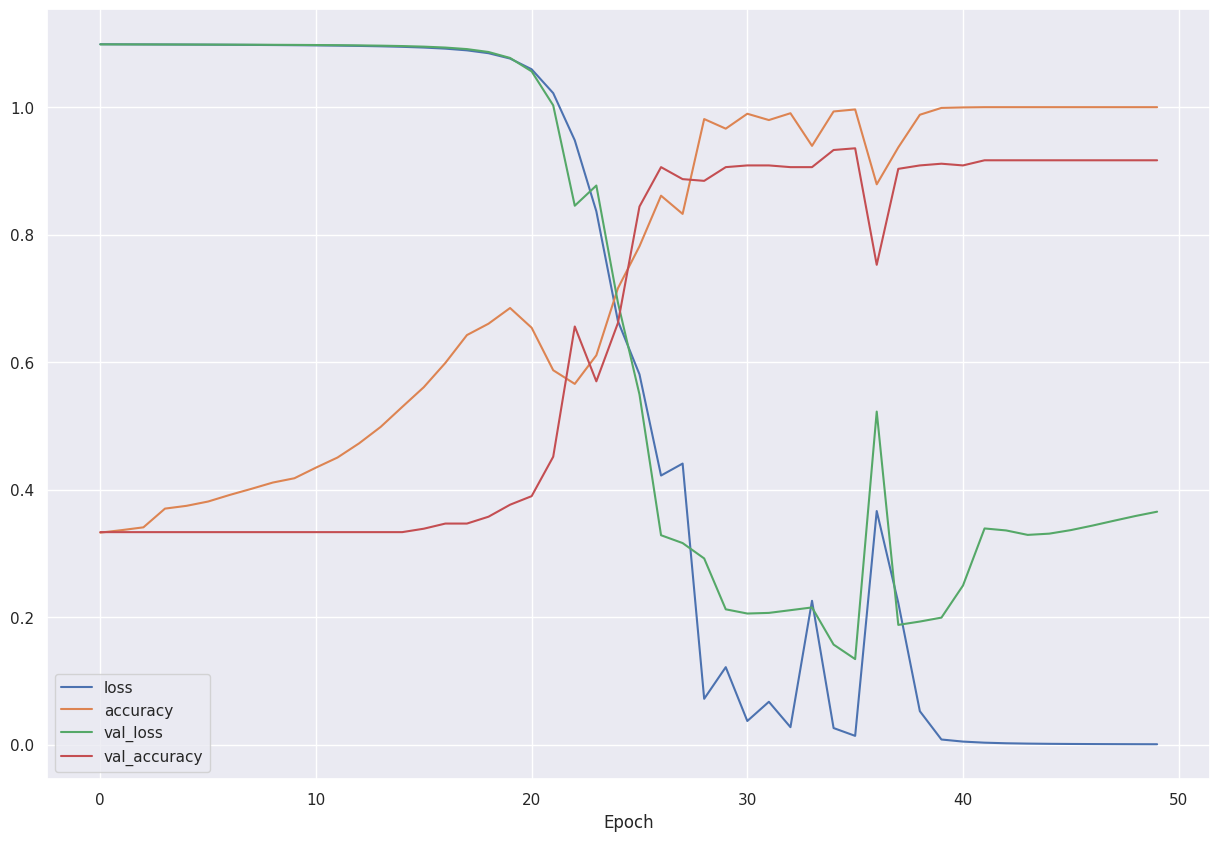

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

Not only did we substantially decrease the number of parameters, but we also observed a slight improvement in the model's performance on the validation set compared to AlexNet. Now, let's try out the architecture on the TF Flowers Dataset to determine if it consistently outperforms AlexNet.

# TF Flowers Dataset

I will now load the TF Flowers Dataset and proceed to train the model on this dataset. During the training process, I will employ the various learning rate schedulers that we previously discussed.

In [ ]:
#https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc : Credit for loading dataset
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
num_classes=5

In [5]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [7]:
from dataprocessing import format_image

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Let's visualize one of the instances from the dataset.

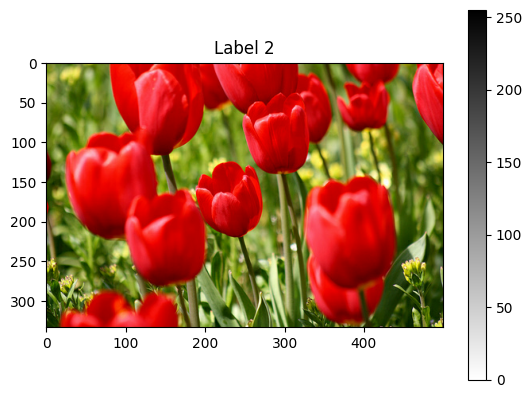

In [8]:
for image, label in training_set.take(5):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

Now let's train the baseline model without any learning rate scheduler.

In [9]:
model=NiNModel(num_classes)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.009)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history=model.fit(train_batches, epochs=50, validation_data=validation_batches)

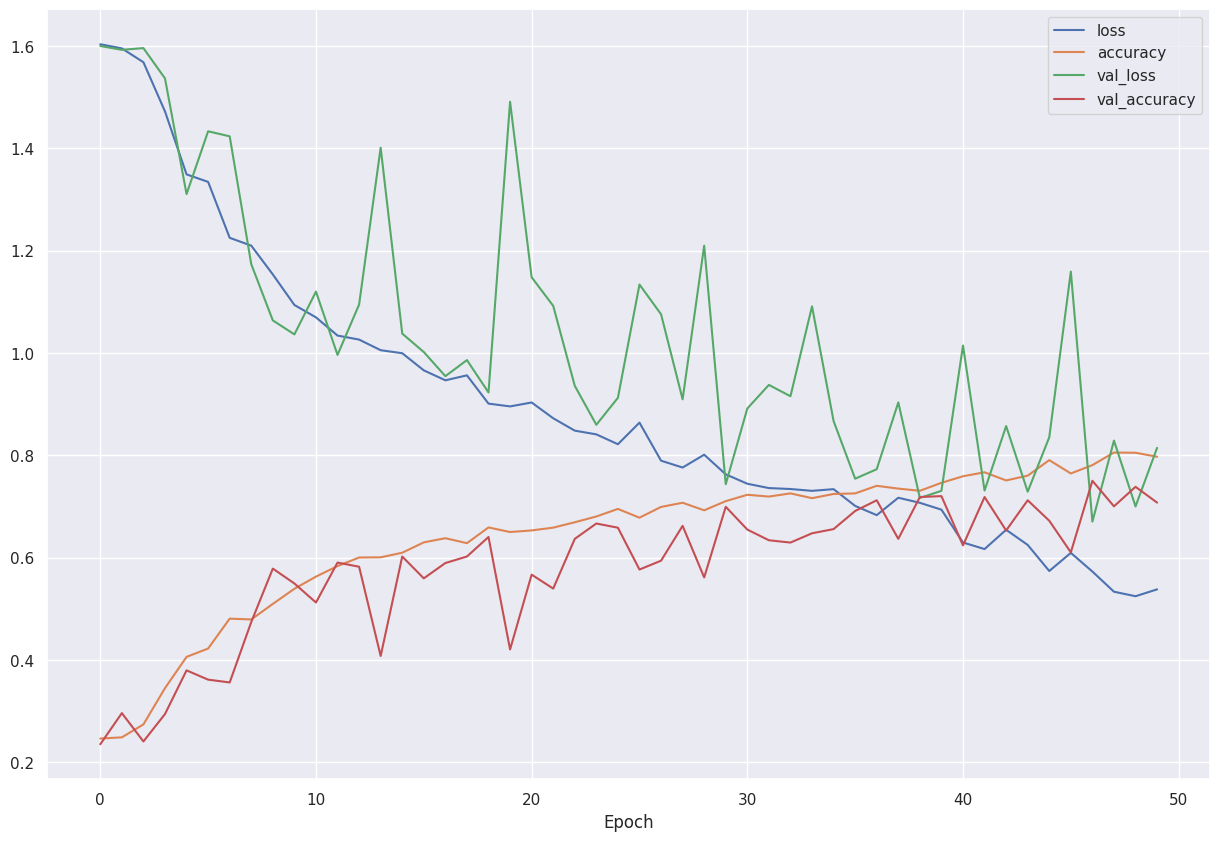

In [11]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

The baseline model exhibited a slight performance advantage over AlexNet. Now, let's assess whether incorporating learning rate schedulers will alter these outcomes.

In [12]:
from Scheduler import WarmUpCallbackEpoch

In [13]:
model1 = NiNModel(num_classes)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
lr_scheduler = WarmUpCallbackEpoch(num_epochs=50, warmup_epochs=5)
model1.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history=model1.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[lr_scheduler.warm_up_with_cosine_epoch()])

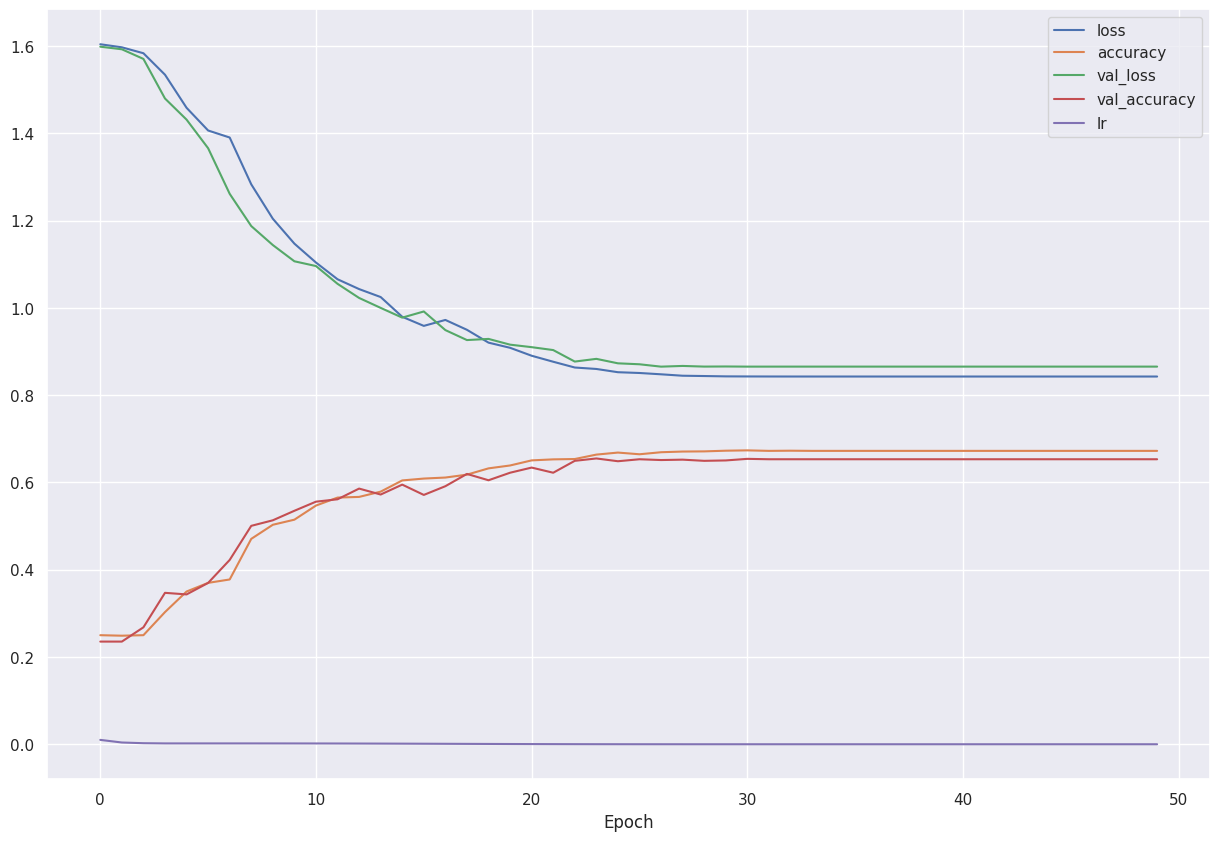

In [15]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [16]:
from Scheduler import WarmUpCallbackBatch

In [17]:
model2 = NiNModel(num_classes)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
warmup_callback = WarmUpCallbackBatch(warmup_steps=2000, initial_lr=0.05, num_epochs=50)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model2.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[warmup_callback], use_multiprocessing = True, workers=4)

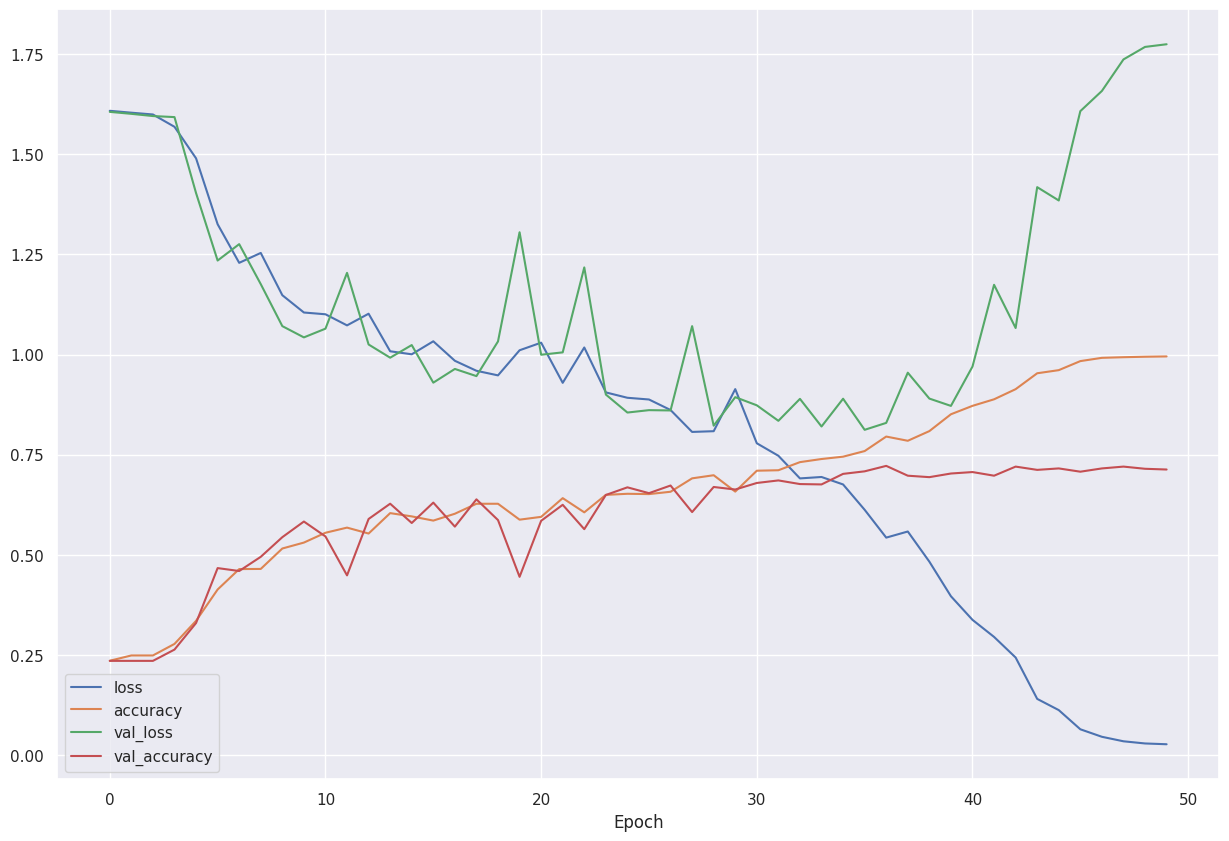

In [19]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [20]:
from Scheduler import WarmUpCosineDecayRestarts

In [ ]:
model3=NiNModel(num_classes)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.09)
warmup_callback = WarmUpCosineDecayRestarts(num_epochs=50,warmup_steps=50, cycle_length=200)
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model3.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[warmup_callback], use_multiprocessing = True, workers=4)

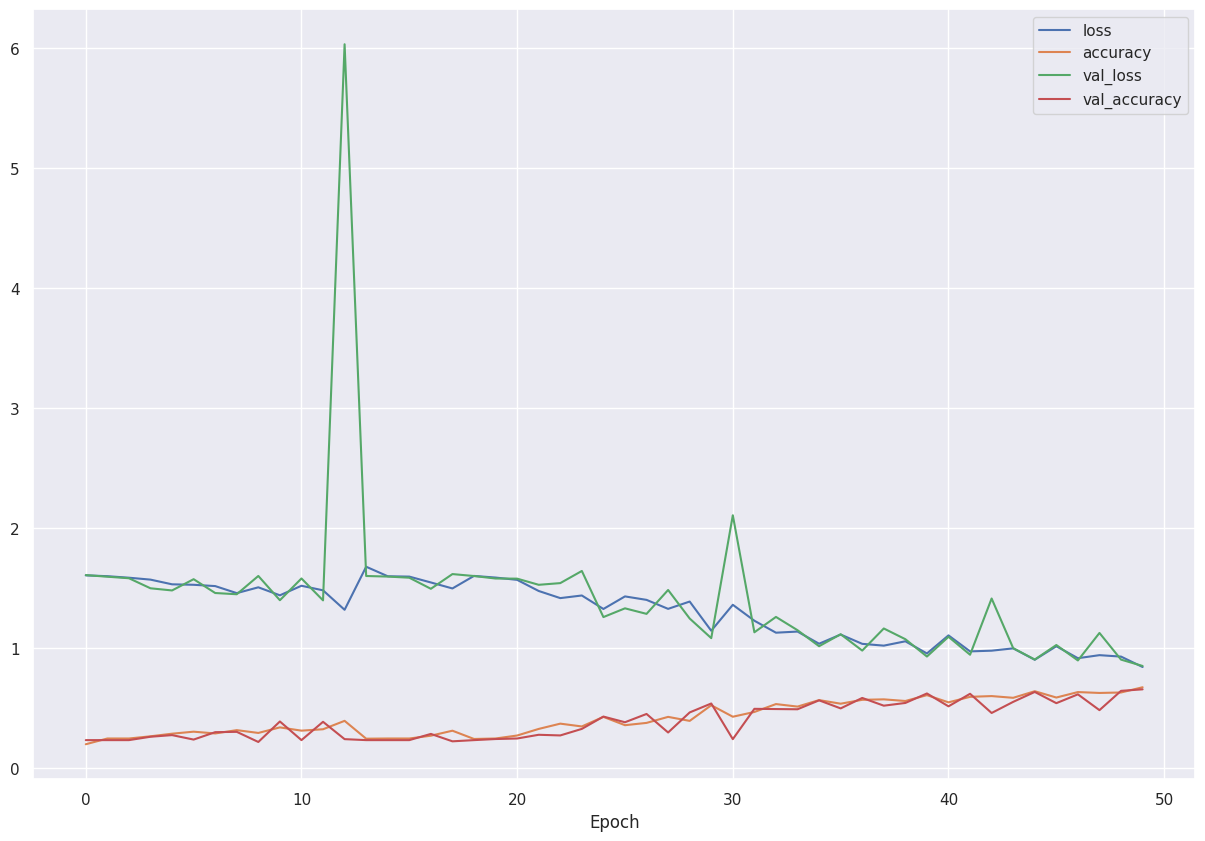

In [22]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

Indeed, NiN continues to demonstrate superior performance compared to AlexNet on this dataset. Its remarkably compact architecture yields impressive results. However, it's important to note that the selection of parameters and dataset must be taken into consideration, as there may be instances where AlexNet outperforms NiN.

## Additional Sources
1. [8.3. Network in Network (NiN)](https://d2l.ai/chapter_convolutional-modern/nin.html)
2. [Review: NIN — Network In Network (Image Classification)](https://towardsdatascience.com/review-nin-network-in-network-image-classification-69e271e499ee)
3. [Network In Network](https://kobiso.github.io/research/research-NIN/)
4. [C4W2L05 Network In Network](https://www.youtube.com/watch?v=c1RBQzKsDCk)
5. [L12/7 Network in Network (NiN)](https://www.youtube.com/watch?v=bBwEnMGcOiA)
6. [NETWORK-IN-NETWORK IMPLEMENTATION USING TENSORFLOW](https://embedai.wordpress.com/2017/07/23/network-in-network-implementation-using-tensorflow/)

## General References

The references below are the main sources I used for preparing the notebooks in this repository.

1. Murphy, K. P. (2022). Probabilistic machine learning: an introduction. MIT press.
2. Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".
3. Chollet, F. (2021). Deep learning with Python. Simon and Schuster.
4. Kar, K. (2020). Mastering Computer Vision with TensorFlow 2. x: Build advanced computer vision applications using machine learning and deep learning techniques. Packt Publishing Ltd.
5. Planche, B., & Andres, E. (2019). Hands-On Computer Vision with TensorFlow 2: Leverage deep learning to create powerful image processing apps with TensorFlow 2.0 and Keras. Packt Publishing Ltd.
6. Lakshmanan, V., Görner, M., & Gillard, R. (2021). Practical Machine Learning for Computer Vision. " O'Reilly Media, Inc.".